# 0. IMPORT STATEMENTS

In [2]:
#!pip install opencv-python
#!pip install scikit-learn
#!pip install imblearn
import cv2
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

# 1. READ-IN DATA TO DF

In [3]:
df = pd.read_csv("labels-map-proj_v3_2.txt", sep=" ", header=None, names=["image", "label"])

# filter all images that end with fv, brt, r90, r180, r270, and fh
df = df[~df["image"].str.contains("fv|brt|r90|r180|r270|fh")]
print(df.shape)
df.head(5)

(10815, 2)


,image,label
0,ESP_013049_0950_RED-0067.jpg,7
7,ESP_019697_2020_RED-0024.jpg,1
14,ESP_015962_1695_RED-0016.jpg,1
21,ESP_013049_0950_RED-0118.jpg,7
28,ESP_015962_1695_RED-0017.jpg,1


In [4]:
df["label"].value_counts()

label
0    8802
1     794
6     298
3     267
4     250
2     166
7     164
5      74
Name: count, dtype: int64

# 2. SHUFFLE

In [5]:
# shuffle the dataframe
df_shuffled = df.sample(frac=1, random_state=1).reset_index(drop=True)
print(df_shuffled.head(5))

X = df_shuffled["image"]
y = df_shuffled["label"]

                          image  label
0  ESP_027475_2310_RED-0112.jpg      0
1  ESP_034557_1510_RED-0201.jpg      0
2  PSP_002455_1320_RED-0111.jpg      2
3  PSP_010587_1620_RED-0342.jpg      0
4  ESP_033955_2065_RED-0059.jpg      0


# 3. TRAIN-TEST-VAL SPLIT

In [6]:
Xp_train_before, Xp_temp, yp_train_before, yp_temp = train_test_split(X, y, test_size=0.4, random_state=42)
Xp_test, Xp_val, yp_test, yp_val = train_test_split(Xp_temp, yp_temp, test_size=0.3, random_state=42)
print(Xp_train_before.shape, yp_train_before.shape, "Train")
print(Xp_test.shape, yp_test.shape, "Test")
print(Xp_val.shape, yp_val.shape, "Validation")

(6489,) (6489,) Train
(3028,) (3028,) Test
(1298,) (1298,) Validation


# 3. DELETE 4.5k IMAGES IN THE TRAIN SET

In [7]:
# delte 7.8k images from the train set that have the label 0 and the corresponding labels in the array y_train
index = Xp_train_before[yp_train_before == 0].sample(n=4500, random_state=42).index
Xp_train = Xp_train_before.drop(index)
yp_train = yp_train_before.drop(index)

print(Xp_train.shape, yp_train.shape)
print("Distribution of labels in the train set")
print(np.unique(yp_train, return_counts=True))
print(np.around(np.unique(yp_train, return_counts=True)[1]/yp_train.shape[0], decimals=4))

(1989,) (1989,)
Distribution of labels in the train set
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([740, 479, 102, 181, 152,  47, 181, 107]))
[0.372  0.2408 0.0513 0.091  0.0764 0.0236 0.091  0.0538]


# 4. READ-IN TO PIXELS AND NORMALIZE

In [8]:
# function that normalizes an input image
def normalize_image(image):
    image = image/255.0
    return image

# function that loads the images from the path in an array and returns the array as well as the correspoding label
def load_images(X, y, folder):
    images = []
    labels = []
    for index in X.index:
        image = cv2.imread(folder+"/"+X[index], cv2.IMREAD_GRAYSCALE)
        image = normalize_image(image)
        if images is not None:
            images.append(image)
            labels.append(y[index])
    return np.array(images), np.array(labels)

In [9]:
# load the images from the train, test, and validation set
X_train, y_train = load_images(Xp_train, yp_train, "map-proj-v3_2")
X_test, y_test = load_images(Xp_test, yp_test, "map-proj-v3_2")
X_val, y_val = load_images(Xp_val, yp_val, "map-proj-v3_2")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(1989, 227, 227) (1989,)
(3028, 227, 227) (3028,)
(1298, 227, 227) (1298,)


In [10]:
print("Distribution of labels in the train set before deleting 5.4k images")
print(np.unique(yp_train_before, return_counts=True))
print(np.around(np.unique(yp_train_before, return_counts=True)[1]/yp_train_before.shape[0], decimals=4))
print("\nDistribution of labels in the train set")
print(np.unique(y_train, return_counts=True))
print(np.around(np.unique(y_train, return_counts=True)[1]/y_train.shape[0], decimals=4))
print("\nDistribution of labels in the test set")
print(np.unique(y_test, return_counts=True))
print(np.around(np.unique(y_test, return_counts=True)[1]/y_test.shape[0], decimals=4))
print("\nDistribution of labels in the validation set")
print(np.unique(y_val, return_counts=True))
print(np.around(np.unique(y_val, return_counts=True)[1]/y_val.shape[0], decimals=4))

Distribution of labels in the train set before deleting 5.4k images
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([5240,  479,  102,  181,  152,   47,  181,  107]))
[0.8075 0.0738 0.0157 0.0279 0.0234 0.0072 0.0279 0.0165]

Distribution of labels in the train set
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([740, 479, 102, 181, 152,  47, 181, 107]))
[0.372  0.2408 0.0513 0.091  0.0764 0.0236 0.091  0.0538]

Distribution of labels in the test set
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([2505,  214,   44,   59,   69,   19,   75,   43]))
[0.8273 0.0707 0.0145 0.0195 0.0228 0.0063 0.0248 0.0142]

Distribution of labels in the validation set
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([1057,  101,   20,   27,   29,    8,   42,   14]))
[0.8143 0.0778 0.0154 0.0208 0.0223 0.0062 0.0324 0.0108]


In [11]:
print(X_train.max(), X_train.min())
print(X_test.max(), X_test.min())
print(X_val.max(), X_val.min())

1.0 0.0
1.0 0.0
1.0 0.0


# 6. IMBALANCE HANDLING

## 6.0 Flatten Images

In [12]:
X_reshaped = X_train.flatten().reshape(X_train.shape[0], 51529)
print(X_train.shape)
print(X_reshaped.shape)

(1989, 227, 227)
(1989, 51529)


## 6.1 ADASYN

In [13]:
adasyn = ADASYN(sampling_strategy="not majority", random_state=1)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_reshaped, y_train) # type: ignore

## 6.2 OVERSAMPLING

In [14]:
oversampler = RandomOverSampler(sampling_strategy="not majority", random_state=3)
X_resampled, y_resampled = oversampler.fit_resample(X_reshaped, y_train) # type: ignore

In [15]:
l1 = pd.DataFrame(X_resampled[np.where(y_resampled == 1)[0]])
print(f"Number of duplicates for the first label after oversampling: {l1.duplicated().sum()}")
all_l = pd.DataFrame(X_resampled)
print(f"Number of duplicates for all labels after oversampling: {all_l.duplicated().sum()}")

Number of duplicates for the first label after oversampling: 261


In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
unique_a, counts_a = np.unique(y_train_adasyn, return_counts=True)
unique_b, counts_b = np.unique(y_resampled, return_counts=True)
print(X_train_adasyn.shape)
print(unique, counts)
print(unique_a, counts_a)
print(unique_b, counts_b)

(5891, 51529)
[0 1 2 3 4 5 6 7] [740 479 102 181 152  47 181 107]
[0 1 2 3 4 5 6 7] [740 701 730 729 748 736 767 740]
[0 1 2 3 4 5 6 7] [740 740 740 740 740 740 740 740]


In [ ]:
X_t_A = X_train_adasyn.reshape(X_train_adasyn.shape[0], 227, 227) # type: ignore
y_t_A = y_train_adasyn

X_t_O = X_resampled.reshape(X_resampled.shape[0], 227, 227) # type: ignore
y_t_O = y_resampled

print(f"Shape of training instances generated by ADASYN: \n{X_t_A.shape}, correspoding y: {y_t_A.shape}")
print(f"Shape of training instances generated by RandomOverSampler: \n{X_t_O.shape}, correspoding y: {y_t_O.shape}")

Shape of training instances generated by ADASYN: 
(5891, 227, 227), correspoding y: (5891,)
Shape of training instances generated by RandomOverSampler: 
(5920, 227, 227), correspoding y: (5920,)


# 7. AUGMENTATION
1. Rotate 90
2. Rotate 180
3. Rotate 270
4. Flip Horizontally
5. Flip Vertically
6. Zoom

In [ ]:
def zoom_at(img, zoom=1.0):
    h, w, = [zoom * i for i in img.shape]
    cx, cy = w/2, h/2
    img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
    img = img[int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
              int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5))]
    return img

def augment_images(images, labels):
    """
    Augments a numpy array of images by rotating them by 90, 180, and 270 degrees, flipping them horizontally and
    vertically, and zooming in on them.
    
    Args:
    - images (numpy.ndarray): A numpy array of shape (N, H, W, C), where N is the number of images, H and W are the
                              height and width of the images, and C is the number of color channels.
                              
    Returns:
    - augmented_images (numpy.ndarray): A numpy array of shape (7N, H, W, C), where the first N images are the
                                         original images and the remaining 6N images are the augmented images.
    """
    # Initialize an empty numpy array to store the augmented images
    augmented_images = np.empty((7*images.shape[0], images.shape[1], images.shape[2]))
    augmented_labels = np.empty((7*images.shape[0]))
    

    # Loop through each image in the array and perform the augmentations
    for i in range(images.shape[0]):
        image = images[i]
        label = labels[i]

        # Add the original image to the output array
        augmented_images[(i*7)] = image
        augmented_labels[(i*7)] = label
        
        # Rotate the image by 90 degrees
        rotated_90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        augmented_images[(i*7)+1] = rotated_90
        augmented_labels[(i*7)+1] = label
        
        # Rotate the image by 180 degrees
        rotated_180 = cv2.rotate(image, cv2.ROTATE_180)
        augmented_images[(i*7)+2] = rotated_180
        augmented_labels[(i*7)+2] = label
        
        # Rotate the image by 270 degrees
        rotated_270 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        augmented_images[(i*7)+3] = rotated_270
        augmented_labels[(i*7)+3] = label
        
        # Flip the image horizontally
        flipped_horizontal = cv2.flip(image, 1)
        augmented_images[(i*7)+4] = flipped_horizontal
        augmented_labels[(i*7)+4] = label
        
        # Flip the image vertically
        flipped_vertical = cv2.flip(image, 0)
        augmented_images[(i*7)+5] = flipped_vertical
        augmented_labels[(i*7)+5] = label
        
        # Zoom in on the image
        zoomed_in = zoom_at(image, 1.2)
        augmented_images[(i*7)+6] = zoomed_in
        augmented_labels[(i*7)+6] = label

        #print(f"Image, {i} done")

    return augmented_images, augmented_labels

In [1]:
index = X_t_A[y_t_A == 0].sample(n=100, random_state=42).index
X_t_A_A, y_t_A_A = augment_images(X_t_A[index], y_t_A[[index]])
X_t_O_A, y_t_O_A = augment_images(X_t_O[index], y_t_O[index])

NameError: name 'X_t_A' is not defined

In [ ]:
X_t_A_A, y_t_A_A = augment_images(X_t_A, y_t_A)
X_t_O_A, y_t_O_A = augment_images(X_t_O, y_t_O)
print(f"Shape of original training data for ADASYN: {X_t_A.shape} with corresponding y: {y_t_A.shape}")
print(f"Shape of augmented training data for ADASYN: {X_t_A_A.shape} with corresponding y: {y_t_A_A.shape}")
print(f"Shape of original training data for RandomOverSampler: {X_t_O.shape} with corresponding y: {y_t_O.shape}")
print(f"Shape of augmented training data for RandomOverSampler: {X_t_O_A.shape} with corresponding y: {y_t_O_A.shape}")

In [19]:
aug_names = ["Original", "Rotate90", "Rotate180", "Rotate270", "Flip Horizontal", "Flip Vertical", "Zoom"]
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

# function that generates 10 random integers from numpy array that are divisible by 7
def generate_random_integers(X, n):
    random_integers = []
    while len(random_integers) < n:
        integer = np.random.randint(0, len(X))
        if integer % 7 == 0:
            random_integers.append(integer)
    return random_integers

# create function that takes 10 random images from the augmented training data and plots them
def plot_augmented_images(X, y, aug_names, class_names, num_images):
    indices = generate_random_integers(X, num_images)
    fig, axes = plt.subplots(len(indices), 7, figsize=(15, 15))
    c = 0
    for i in indices:
        for j in range(7):
            axes[c, j].imshow(X[i+j], cmap="gray")
            axes[c, j].set_xticks([])
            axes[c, j].set_yticks([])
            
            axes[c, j].set_xlabel(aug_names[j] + " " + str(int(i+j)))
            if j == 0:
                axes[c, j].set_ylabel(class_names[int(y[i+j])])
        c += 1
    plt.show()

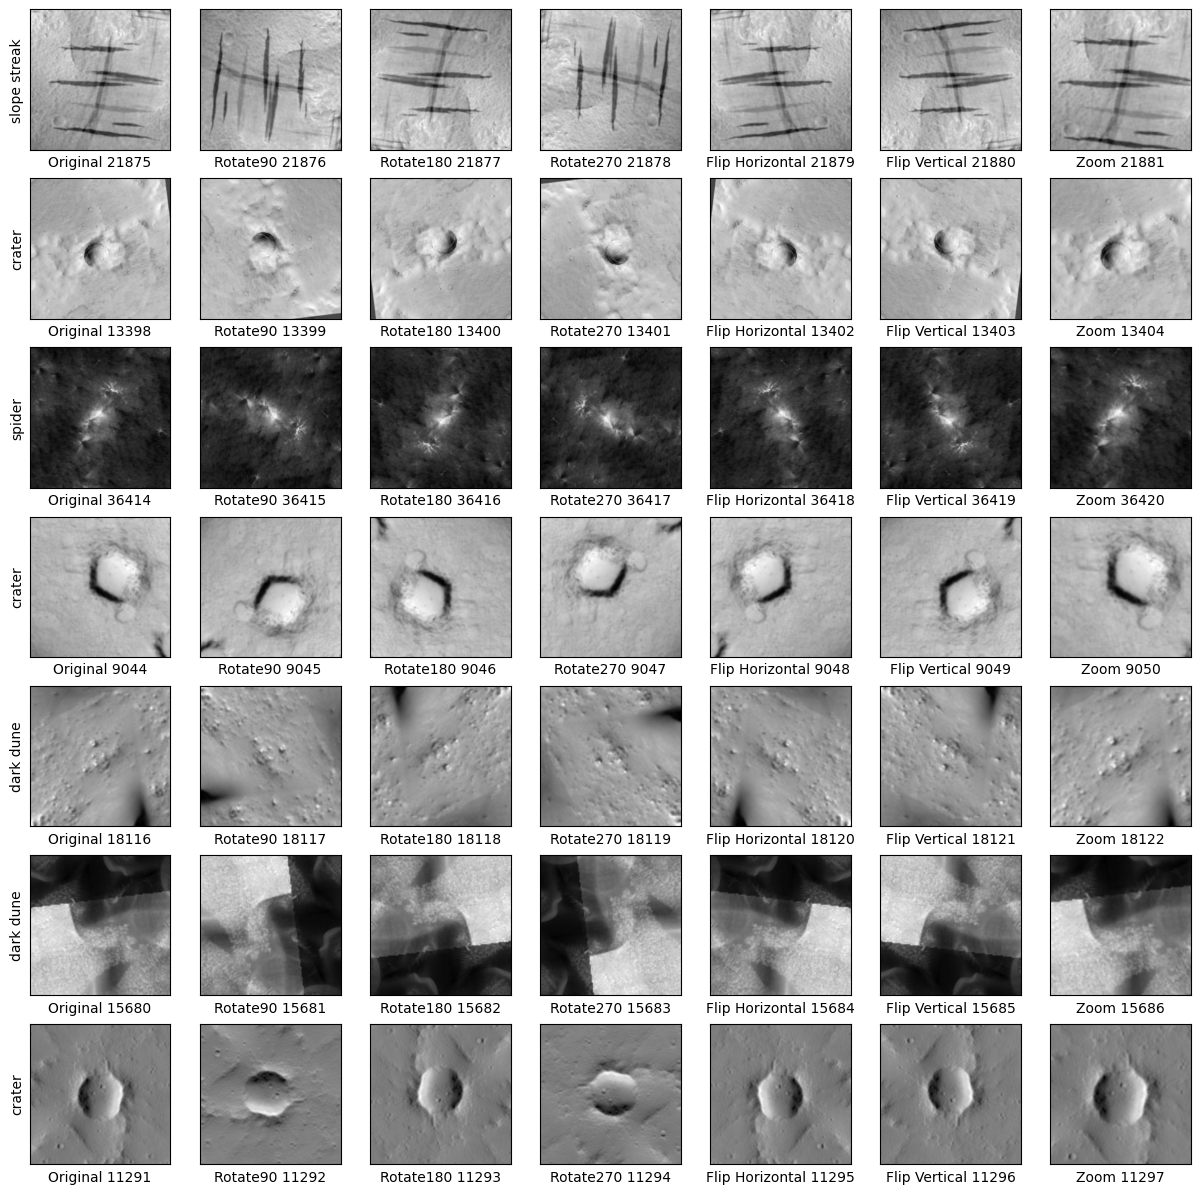

In [20]:
plot_augmented_images(X_t_A_A, y_t_A_A, aug_names, class_names, 7)

# 8 Apply Models

In [21]:
#!pip install tensorflow
import datetime
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Input, AveragePooling2D, concatenate
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import seaborn as sns

# Load the TensorBoard notebook extension
%load_ext tensorboard

np.random.seed(1000)

In [22]:
def shuffle_data(x, y):
    assert x.shape[0] == y.shape[0]
    p = np.random.permutation(x.shape[0])
    return x[p], y[p]

In [23]:
def model_evaluation(model, history, X_test, y_test, class_names):
    sns.lineplot(data=history.history['accuracy'], label='accuracy')
    sns.lineplot(data=history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

    test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
    print("Accuracy on the training set:", test_acc)
    y_pred_prob = model.predict(X_test)
    y_pred_class = y_pred_prob.argmax(axis=-1)

    print(classification_report(y_pred_class, y_test, target_names=class_names))
    fig = plt.figure(figsize=(10, 6))
    sns.heatmap(confusion_matrix(y_pred_class, y_test), xticklabels=class_names, yticklabels=class_names, annot=True)
    plt.show()

## ALEX

In [24]:
def run_alex(X_train, y_train, X_val, y_val, X_test, y_test, learning_rate, weight_decay, momentum, batch_size, epochs, class_names, folder):
    alex = Sequential()
    
    alex.add(Conv2D(filters=96, input_shape=(227, 227, 1), kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu'))
    alex.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    alex.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu'))
    alex.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    alex.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    alex.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    alex.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    alex.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    alex.add(Flatten())
    alex.add(Dense(4096, input_shape=(227*227*1,), activation='relu'))
    alex.add(Dropout(0.5))
    alex.add(Dense(4096, activation='relu'))
    alex.add(Dropout(0.5))
    alex.add(Dense(8))
    alex.add(Activation('softmax'))
    
    alex.summary()
    
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, decay=weight_decay, momentum=momentum, nesterov=True)
    loss_function = keras.losses.SparseCategoricalCrossentropy()
    
    alex.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
    
    # Tensorboard
    log_dir = folder + "/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    history = alex.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

    model_evaluation(alex, history, X_test, y_test, class_names)

    return alex, history

## GOOGLE

In [25]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    path1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(path2)
    path3 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(path3)
    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(path4)
    return concatenate([path1, path2, path3, path4], axis=-1)

def GoogLeNet():
    input_layer = Input(shape=(227, 227, 1))

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)

    x = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid')(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(1000, activation='sigmoid')(x)
    output_layer = Dense(8, activation='softmax')(x)

    # Define the model
    model_googlenet = keras.Model(input_layer, output_layer)

    # Return the model
    return model_googlenet

def run_google(X_train, y_train, X_val, y_val, X_test, y_test, learning_rate, momentum, batch_size, epochs, class_names, folder):
    google = GoogLeNet()
    
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
    loss_function = keras.losses.SparseCategoricalCrossentropy()
    
    google.compile(optimizer=optimizer, loss=loss_function, metrics=["accuracy"])
    
    # Tensorboard
    log_dir = folder + "/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    history = google.fit(X_t_A_A_S, y_t_A_A_S, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
    
    model_evaluation(google, history, X_test, y_test, class_names)
    
    return google, history

# 8.1 AlexNet Oversampled Data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        11712     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 384)         1

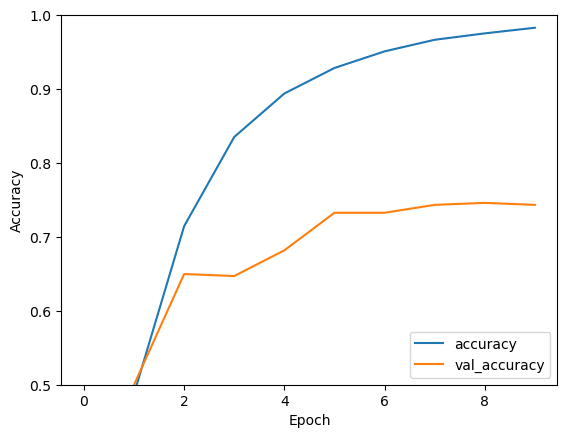

28/28 - 3s - loss: 1.2648 - accuracy: 0.7856 - 3s/epoch - 89ms/step
Accuracy on the training set: 0.7855504751205444
28/28 [==============================] - 3s 108ms/step
               precision    recall  f1-score   support

        other       0.78      0.75      0.76       312
       crater       0.90      0.86      0.88       251
    dark dune       0.76      0.81      0.79        48
 slope streak       0.71      0.59      0.64        80
  bright dune       0.92      0.95      0.94        64
impact ejecta       0.25      0.67      0.36         9
 swiss cheese       0.64      0.86      0.73        57
       spider       0.69      0.69      0.69        51

     accuracy                           0.79       872
    macro avg       0.71      0.77      0.72       872
 weighted avg       0.80      0.79      0.79       872



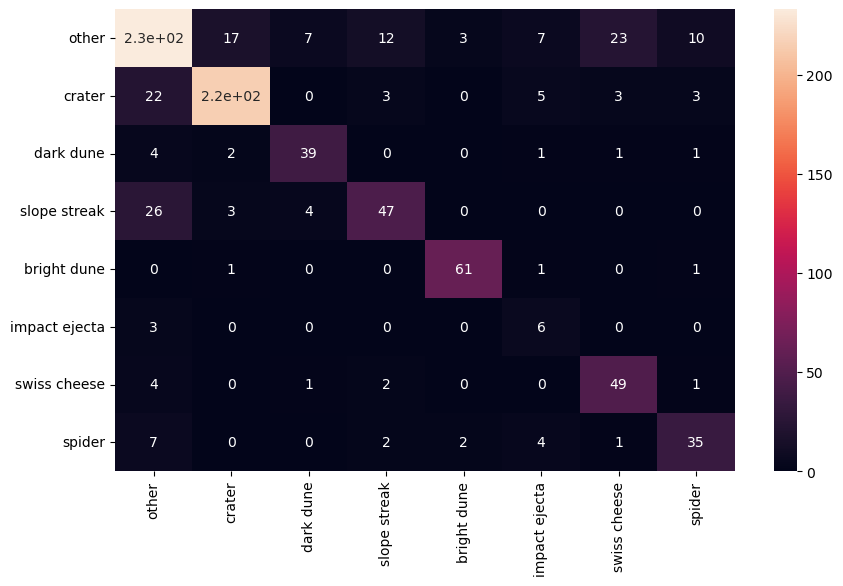

In [26]:
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

X_t_A_A_S, y_t_A_A_S, = shuffle_data(X_t_A_A, y_t_A_A)
X_t_O_A_S, y_t_O_A_S, = shuffle_data(X_t_O_A, y_t_O_A)

folder = "logs_Alex_Over"
# Clear any logs from previous runs
!rm -rf ./logs_Alex_Over/

# Hyperparameters
learning_rate = 0.01
weight_decay = 0.0005
momentum = 0.9
batch_size = 32 #128
epochs = 10 #90

alex_O, history_alex_O = run_alex(X_train=X_t_O_A_S, y_train=y_t_O_A_S, 
                                 X_val=X_val, y_val=y_val,
                                 X_test=X_test, y_test=y_test,
                                 learning_rate=learning_rate, weight_decay=weight_decay, momentum=momentum,
                                 batch_size=batch_size, epochs=epochs,
                                 class_names=class_names, folder=folder)

# 8.2 AlexNet ADASYN Data

class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

X_t_O_A_S, y_t_O_A_S, = shuffle_data(X_t_O_A, y_t_O_A)
X_t_A_A_S, y_t_A_A_S, = shuffle_data(X_t_A_A, y_t_A_A)

folder = "logs_Alex_ADASYN"
# Clear any logs from previous runs
!rm -rf ./logs_Alex_ADASYN/

# Hyperparameters
learning_rate = 0.01
weight_decay = 0.0005
momentum = 0.9
batch_size = 32 #128
epochs = 10 #90

alex_O, history_alex_O = run_alex(X_train=X_t_A_A_S, y_train=y_t_A_A_S, 
                                 X_val=X_val, y_val=y_val,
                                 X_test=X_test, y_test=y_test,
                                 learning_rate=learning_rate, weight_decay=weight_decay, momentum=momentum,
                                 batch_size=batch_size, epochs=epochs,
                                 class_names=class_names, folder=folder)

# 8.3 GoogleNet Oversampled Data

class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

X_t_O_A_S, y_t_O_A_S, = shuffle_data(X_t_O_A, y_t_O_A)
X_t_A_A_S, y_t_A_A_S, = shuffle_data(X_t_A_A, y_t_A_A)

folder = "logs_Google_Over"
# Clear any logs from previous runs
!rm -rf ./logs_Google_Over/

# Hyperparameters
learning_rate = 0.01
momentum = 0.9
batch_size = 32 #128
epochs = 1 #90

google_O, history_google_O = run_google(X_train=X_t_O_A_S, y_train=y_t_O_A_S, 
                                        X_val=X_val, y_val=y_val,
                                        X_test=X_test, y_test=y_test,
                                        learning_rate=learning_rate, momentum=momentum,
                                        batch_size=batch_size, epochs=epochs,
                                        class_names=class_names, folder=folder)

# 8.4 GoogleNet ADASYN Data

In [ ]:
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

X_t_O_A_S, y_t_O_A_S, = shuffle_data(X_t_O_A, y_t_O_A)
X_t_A_A_S, y_t_A_A_S, = shuffle_data(X_t_A_A, y_t_A_A)

folder = "logs_Google_ADASYN"
# Clear any logs from previous runs
!rm -rf ./logs_Google_ADASYN/

# Hyperparameters
learning_rate = 0.01
momentum = 0.9
batch_size = 32 #128
epochs = 10 #90

google_O, history_google_O = run_google(X_train=X_t_A_A_S, y_train=y_t_A_A_S, 
                                        X_val=X_val, y_val=y_val,
                                        X_test=X_test, y_test=y_test,
                                        learning_rate=learning_rate, momentum=momentum,
                                        batch_size=batch_size, epochs=epochs,
                                        class_names=class_names, folder=folder)

Epoch 1/10
 740/1200 [=================>............] - ETA: 12:08 - loss: 2.0532 - accuracy: 0.1851